<a href="https://colab.research.google.com/github/someshkr/Geo-Copula/blob/main/earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install geopy
!pip install geopandas
!pip install shapely
!pip install fiona
!pip install pyproj 
!pip install rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import tensorflow as tf
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense

from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import rtree
import shapely
import fiona
import pyproj


In [39]:
# df = pd.read_excel("/content/query.xlsx")

df = pd.read_excel("/content/drive/MyDrive/geocopula/query.xlsx")
# df = pd.read_csv("/dbfs/FileStore/data/Indian_earthquake_data.csv")
df['time'] = pd.to_datetime(df['time'],utc=True)
df = df[['time','latitude','longitude','depth','mag']]
df = df.sort_values(by='time',ascending=True)
df.head()

,time,latitude,longitude,depth,mag
17836,2000-09-17 05:18:04.270000+00:00,38.006,140.670,105.1,4.5
17835,2000-09-17 21:04:24.900000+00:00,30.257,138.392,445.6,4.3
17834,2000-09-21 22:43:24.770000+00:00,35.811,140.837,45.2,4.8
17833,2000-09-23 17:42:10.600000+00:00,41.444,142.217,63.9,4.3
17832,2000-09-25 16:22:01.020000+00:00,32.167,142.461,33.0,4.1


In [40]:
df_train = df.iloc[:12512]
df_val = df.iloc[12512:14271]
df_test = df.iloc[14271:]
df_train = df_train.set_index('time')
df_val = df_val.set_index('time')
df_test = df_test.set_index('time')

In [41]:
x_train,y_train= df_train[['latitude','longitude','depth']],df_train[['mag']]
x_test,y_test= df_test[['latitude','longitude','depth']],df_test[['mag']]
x_val,y_val  = df_val[['latitude','longitude','depth']],df_val[['mag']]

In [42]:
x_train.shape

(12512, 3)

In [43]:
batch_size = 32
buffer_size = x_train.shape[0]
# Provide an infinite dataset
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
train_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_train), np.array(y_train))).shuffle(buffer_size).batch(batch_size).repeat()
# Provide an infinite dataset
val_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_val), np.array(y_val))).batch(batch_size).repeat()
test_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_test), np.array(y_test))).batch(batch_size).repeat()

In [44]:
print("x_train shape ",x_train.shape)
print("x_test shape ",x_test.shape)
print("x_val shape ",x_val.shape)
print("y_train shape ",y_train.shape)
print("y_test shape ",y_test.shape)
print("y_val shape ",y_val.shape)
print(val_iterator)
print(test_iterator)

x_train shape  (12512, 3, 1)
x_test shape  (3566, 3, 1)
x_val shape  (1759, 3, 1)
y_train shape  (12512, 1)
y_test shape  (3566, 1)
y_val shape  (1759, 1)
<RepeatDataset element_spec=(TensorSpec(shape=(None, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


# **Bi-directional LSTM**

In [45]:
n_steps = x_train.shape[-2]
n_features = x_train.shape[-1]
# Define the model
model = Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
#model.add(tf.keras.layers.Reshape((128, 1), input_shape = (128, )))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [46]:
n_steps,n_features

(3, 1)

In [47]:
# train_iterator
# X = X.reshape((X.shape[0], X.shape[1], n_features))

In [48]:
epochs = 10
steps_per_epoch = 800
validation_steps = 80
# Train with an infinite dataset
history = model.fit(train_iterator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_iterator,
                    validation_steps=validation_steps)
print('=======================')
model.summary()

Epoch 1/10
800/800 [==============================] - 11s 8ms/step - loss: 0.5236 - val_loss: 0.1350
Epoch 2/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2319 - val_loss: 0.1382
Epoch 3/10
800/800 [==============================] - 5s 7ms/step - loss: 0.2324 - val_loss: 0.1387
Epoch 4/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2329 - val_loss: 0.1579
Epoch 5/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2332 - val_loss: 0.1368
Epoch 6/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2320 - val_loss: 0.1372
Epoch 7/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2335 - val_loss: 0.1341
Epoch 8/10
800/800 [==============================] - 5s 7ms/step - loss: 0.2329 - val_loss: 0.1742
Epoch 9/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2326 - val_loss: 0.1400
Epoch 10/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2309 - val_loss: 0.141

In [49]:
len(model.predict(np.array(x_test)).reshape(-1))

112/112 [==============================] - 1s 2ms/step


3566

In [50]:
x_test.shape

(3566, 3, 1)

In [51]:
df_final = df_test.copy()
df_final['yhat']=model.predict(np.array(x_test)).reshape(-1)

112/112 [==============================] - 1s 5ms/step


# **CNN LSTM**

In [15]:
x_train,y_train= df_train[['latitude','longitude','depth']],df_train[['mag']]
x_test,y_test= df_test[['latitude','longitude','depth']],df_test[['mag']]
x_val,y_val  = df_val[['latitude','longitude','depth']],df_val[['mag']]

print(x_train.shape)

batch_size = 32
buffer_size = x_train.shape[0]
# Provide an infinite dataset
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

x_train = x_train.reshape((x_train.shape[0],1, x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0],1, x_test.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0],1, x_val.shape[1], 1))
train_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_train), np.array(y_train))).shuffle(buffer_size).batch(batch_size).repeat()
# Provide an infinite dataset
val_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_val), np.array(y_val))).batch(batch_size).repeat()
test_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_test), np.array(y_test))).batch(batch_size).repeat()

print(train_iterator)



(12512, 3)
<RepeatDataset element_spec=(TensorSpec(shape=(None, 1, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [16]:
n_steps = x_train.shape[-2]
n_features = x_train.shape[-1]
# Define the model
model = Sequential()

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu',input_shape=(None,64,1))))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# model.fit(X, y, epochs=500, verbose=0)

In [17]:
print(n_steps,n_features)

3 1


In [18]:
epochs = 10
steps_per_epoch = 800
validation_steps = 80
# Train with an infinite dataset
history = model.fit(train_iterator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_iterator,
                    validation_steps=validation_steps)
print('=======================')
model.summary()

Epoch 1/10
800/800 [==============================] - 5s 4ms/step - loss: 0.2683 - val_loss: 0.1867
Epoch 2/10
800/800 [==============================] - 3s 4ms/step - loss: 0.2523 - val_loss: 0.1890
Epoch 3/10
800/800 [==============================] - 3s 4ms/step - loss: 0.2474 - val_loss: 0.1597
Epoch 4/10
800/800 [==============================] - 3s 4ms/step - loss: 0.2485 - val_loss: 0.1510
Epoch 5/10
800/800 [==============================] - 3s 4ms/step - loss: 0.2443 - val_loss: 0.1512
Epoch 6/10
800/800 [==============================] - 3s 4ms/step - loss: 0.2493 - val_loss: 0.1613
Epoch 7/10
800/800 [==============================] - 3s 4ms/step - loss: 0.2483 - val_loss: 0.1487
Epoch 8/10
800/800 [==============================] - 3s 4ms/step - loss: 0.2432 - val_loss: 0.1645
Epoch 9/10
800/800 [==============================] - 3s 3ms/step - loss: 0.2475 - val_loss: 0.1540
Epoch 10/10
800/800 [==============================] - 2s 3ms/step - loss: 0.2436 - val_loss: 0.1508

In [52]:
len(model.predict(np.array(x_test)).reshape(-1))

112/112 [==============================] - 0s 3ms/step


3566

In [54]:
x_test.shape

(3566, 3, 1)

In [55]:
df_final = df_test.copy()
df_final['yhat']=model.predict(np.array(x_test)).reshape(-1)

112/112 [==============================] - 0s 2ms/step


# **ConvLSTM**

In [59]:
x_train,y_train= df_train[['latitude','longitude','depth']],df_train[['mag']]
x_test,y_test= df_test[['latitude','longitude','depth']],df_test[['mag']]
x_val,y_val  = df_val[['latitude','longitude','depth']],df_val[['mag']]

print(x_train.shape)

batch_size = 32
buffer_size = x_train.shape[0]
# Provide an infinite dataset
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

x_train = x_train.reshape((x_train.shape[0],1,1, x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0],1,1, x_test.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0],1,1, x_val.shape[1], 1))
train_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_train), np.array(y_train))).shuffle(buffer_size).batch(batch_size).repeat()
# Provide an infinite dataset
val_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_val), np.array(y_val))).batch(batch_size).repeat()
test_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_test), np.array(y_test))).batch(batch_size).repeat()

print(train_iterator)

'''
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))

X = X.reshape((X.shape[0], 2, 1, x_train.shape[-2], x_train.shape[-1]))

n_steps = x_train.shape[-2]
n_features = x_train.shape[-1]
print(n_steps,n_features)

'''



(12512, 3)
<RepeatDataset element_spec=(TensorSpec(shape=(None, 1, 1, 3, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


'\nn_features = 1\nn_seq = 2\nn_steps = 2\nX = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))\n\nX = X.reshape((X.shape[0], 2, 1, x_train.shape[-2], x_train.shape[-1]))\n\nn_steps = x_train.shape[-2]\nn_features = x_train.shape[-1]\nprint(n_steps,n_features)\n\n'

In [61]:

# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(1, 1,  x_train.shape[-2], x_train.shape[-1])))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit(X, y, epochs=500, verbose=0)
# # demonstrate prediction
# x_input = array([60, 70, 80, 90])
# x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [62]:
n_steps = x_train.shape[-2]
n_features = x_train.shape[-1]
print(n_steps,n_features)

3 1


In [63]:
epochs = 10
steps_per_epoch = 800
validation_steps = 80
# Train with an infinite dataset
history = model.fit(train_iterator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_iterator,
                    validation_steps=validation_steps)
print('=======================')
model.summary()

Epoch 1/10
800/800 [==============================] - 8s 7ms/step - loss: 0.4782 - val_loss: 0.1901
Epoch 2/10
800/800 [==============================] - 6s 7ms/step - loss: 0.2469 - val_loss: 0.1556
Epoch 3/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2482 - val_loss: 0.1647
Epoch 4/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2429 - val_loss: 0.1594
Epoch 5/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2462 - val_loss: 0.1809
Epoch 6/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2430 - val_loss: 0.1587
Epoch 7/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2396 - val_loss: 0.1505
Epoch 8/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2382 - val_loss: 0.1514
Epoch 9/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2408 - val_loss: 0.1675
Epoch 10/10
800/800 [==============================] - 6s 7ms/step - loss: 0.2370 - val_loss: 0.1638

# **LSTM**

In [ ]:
x_train,y_train= df_train[['latitude','longitude','depth']],df_train[['mag']]
x_test,y_test= df_test[['latitude','longitude','depth']],df_test[['mag']]
x_val,y_val  = df_val[['latitude','longitude','depth']],df_val[['mag']]

print(x_train.shape)

batch_size = 32
buffer_size = x_train.shape[0]
# Provide an infinite dataset
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

x_train = x_train.reshape((x_train.shape[0],1,1, x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0],1,1, x_test.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0],1,1, x_val.shape[1], 1))
train_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_train), np.array(y_train))).shuffle(buffer_size).batch(batch_size).repeat()
# Provide an infinite dataset
val_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_val), np.array(y_val))).batch(batch_size).repeat()
test_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_test), np.array(y_test))).batch(batch_size).repeat()

print(train_iterator)


In [20]:

# # split a univariate sequence
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)

# # define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# n_steps = 3
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)
# # reshape from [samples, timesteps] into [samples, timesteps, features]
# n_features = 1
# print(X.shape)
# X = X.reshape((X.shape[0], X.shape[1], n_features))
# print(X.shape)

In [53]:
# # univariate cnn lstm example
# from numpy import array
# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers import TimeDistributed
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D

# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)

# # define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# n_steps = 4
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)
# # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
# n_features = 1
# n_seq = 2
# n_steps = 2
# print(X.shape[0], n_seq, n_steps, n_features)
# print(X.shape)
# print(X)
# X = X.reshape((X.shape[0], n_seq, n_steps, n_features))


# # define model
# model = Sequential()
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
# model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(50, activation='relu'))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
# # # fit model
# # model.fit(X, y, epochs=500)
# # # demonstrate prediction
# # x_input = array([60, 70, 80, 90])
# # x_input = x_input.reshape((1, n_seq, n_steps, n_features))
# # yhat = model.predict(x_input, verbose=0)
# # print(yhat)


In [25]:
# epochs = 10
# steps_per_epoch = 800
# validation_steps = 80
# # Train with an infinite dataset
# x_train = np.array(x_train)
# x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# history = model.fit(x_train, y_train,epochs=epochs,
#                     steps_per_epoch=steps_per_epoch
#                    )
# print('=======================')
# model.summary()

In [26]:

#for batch_num, (x, y) in enumerate(test_iterator.take(3)):
  
len(model.predict(np.array(x_test)).reshape(-1))

In [27]:

# yhat = model.predict(np.array(x_test), verbose=0).reshape(-1)


In [28]:
# x_test.shape

(3566, 1, 3, 1)

In [56]:
# df_final = df_test.copy()
# df_final['yhat']=model.predict(np.array(x_test)).reshape(-1)

In [ ]:
df_final.head()

,latitude,longitude,depth,mag,yhat
time,,,,,
2016-10-20 02:49:53.120000+00:00,35.8196,140.5082,18.91,5.3,4.583576
2016-10-20 19:07:26.450000+00:00,41.9161,140.8357,154.05,4.2,4.229105
2016-10-21 05:07:22.990000+00:00,35.3743,133.8092,5.63,6.2,4.383457
2016-10-21 05:30:07.340000+00:00,35.5001,133.5914,10.00,4.1,4.356168
2016-10-21 05:33:58.790000+00:00,35.3563,133.8545,10.00,4.0,4.352921


In [ ]:
# # univariate lstm example
# from numpy import array
# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense
 
# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)
 
# # define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# n_steps = 3
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)

# # reshape from [samples, timesteps] into [samples, timesteps, features]
# n_features = 1
# print('++++++++++++++++++++++++++++++++++++++++++++++++')
# print(X.shape)
# X = X.reshape((X.shape[0], X.shape[1], n_features))
# print(X.ndim)
# # define model
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit(X, y, epochs=200, verbose=0)
# # demonstrate prediction
# x_input = array([70, 80, 90])
# x_input = x_input.reshape((1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

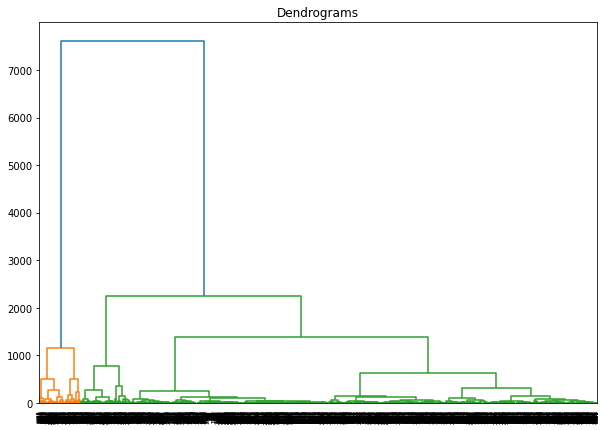

In [ ]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
df_dend = df_final.drop(['mag'],axis=1) 
dend = shc.dendrogram(shc.linkage(df_dend, method='ward'))

In [ ]:
cluster = AgglomerativeClustering(n_clusters=2).fit(df_dend)
df_dend['labels'] = cluster.labels_

In [ ]:
df_dend.head()

,latitude,longitude,depth,yhat,labels
time,,,,,
2016-10-20 02:49:53.120000+00:00,35.8196,140.5082,18.91,4.583576,0
2016-10-20 19:07:26.450000+00:00,41.9161,140.8357,154.05,4.229105,2
2016-10-21 05:07:22.990000+00:00,35.3743,133.8092,5.63,4.383457,0
2016-10-21 05:30:07.340000+00:00,35.5001,133.5914,10.00,4.356168,0
2016-10-21 05:33:58.790000+00:00,35.3563,133.8545,10.00,4.352921,0


In [ ]:
df_1 = df_dend.loc[(df_dend['labels']==0)]
df_2 = df_dend.loc[(df_dend['labels']==1)]
df_3 = df_dend.loc[(df_dend['labels']==2)]
# df_4 = df_dend.loc[(df_dend['labels']==3)]

# *Plotting the coordinates based on the above cluster*

In [ ]:
import fsspec


# with fsspec.open("/content/data.zip") as file:
with fsspec.open("/content/drive/MyDrive/geocopula/japan_data.zip") as file:
    jap = gpd.read_file(file)


# geometry = [Point(xy) for xy in zip(df_1['longitude'],df_1['latitude'])]
# gdf = GeoDataFrame(df_1,geometry=geometry)
# gdf.plot(ax=jap.plot(figsize=(25, 25)), marker='o', color='red', markersize=15);

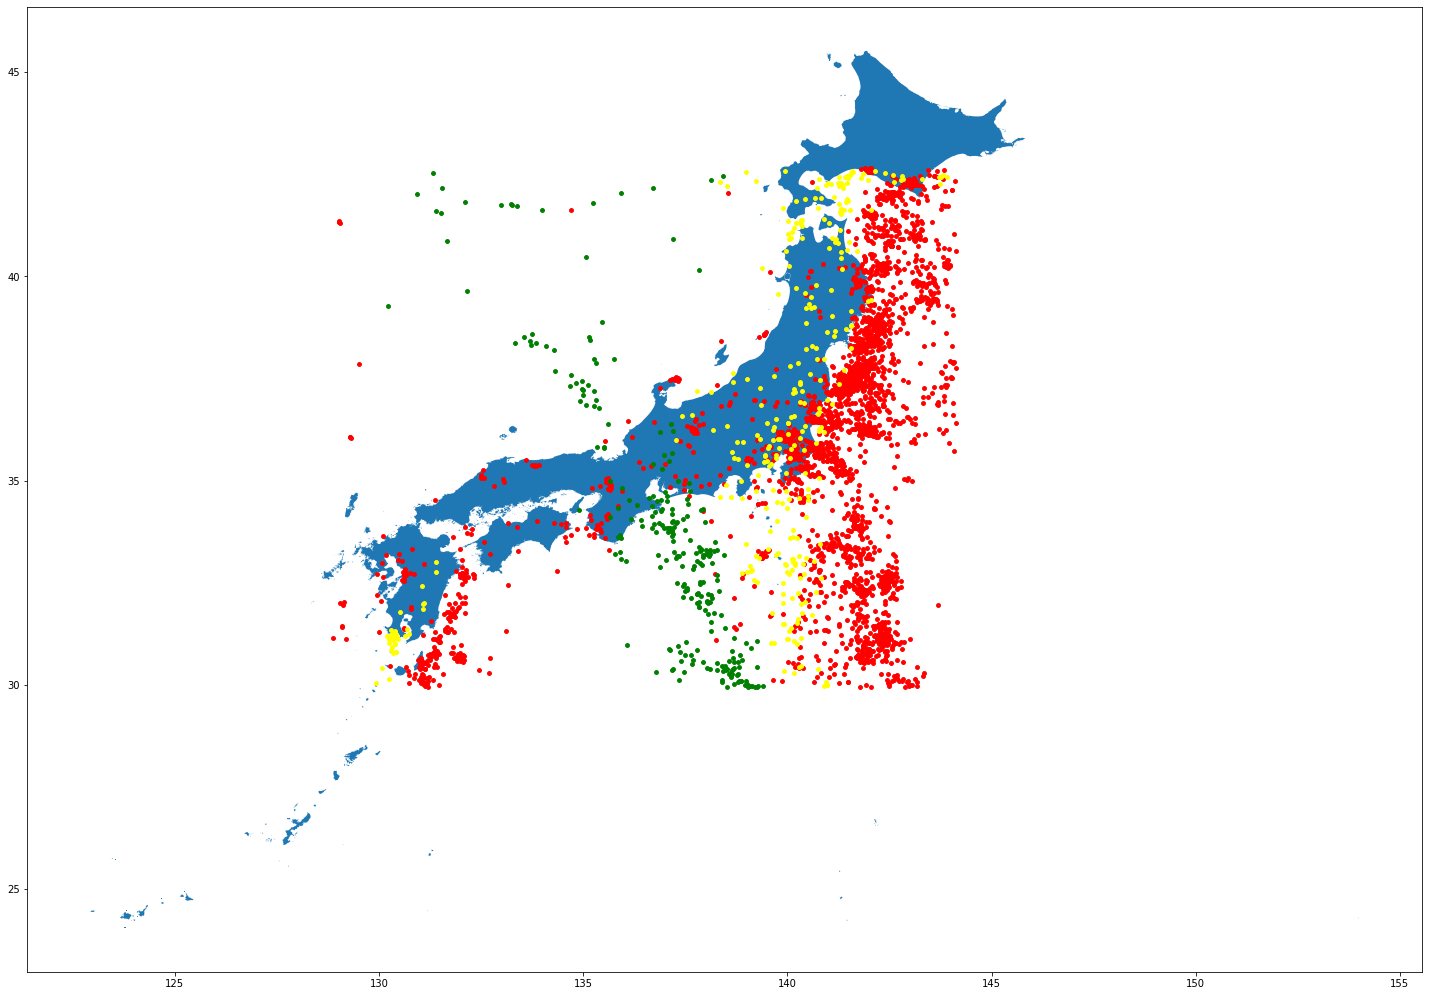

In [ ]:

gdf1 = GeoDataFrame(df_1,geometry=[Point(xy) for xy in zip(df_1['longitude'],df_1['latitude'])])
gdf2 = GeoDataFrame(df_2,geometry=[Point(xy) for xy in zip(df_2['longitude'],df_2['latitude'])])
gdf3 = GeoDataFrame(df_3,geometry=[Point(xy) for xy in zip(df_3['longitude'],df_3['latitude'])])
a = gdf1.plot(ax=jap.plot(figsize=(25, 25)), marker='o', color='Red', markersize=15);
b = gdf2.plot(ax=a, marker='o', color='Green', markersize=15);
c = gdf3.plot(ax=b, marker='o', color='Yellow', markersize=15);


In [ ]:
# geometry = [Point(xy) for xy in zip(df_2['longitude'],df_2['latitude'])]
# gdf = GeoDataFrame(df_2,geometry=geometry)
# gdf.plot(ax=jap.plot(figsize=(25, 25)), marker='o', color='Green', markersize=15);

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



POINT (1641872809120311.5 -35.374780654049744)


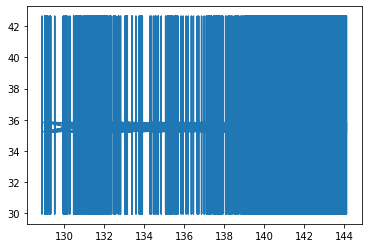

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

# LON, LAT
vertices = [(i,j) for i in df_1['longitude'].values for j in df_1['latitude'].values]

p1 = Polygon(vertices)
print(p1)
print(p1.area)
print(p1.bounds)
print(p1.centroid)

plt.plot( [v[0] for v in vertices], [v[1] for v in vertices] )
plt.show()

In [ ]:
#https://github.com/Soroush98/LSTM-CNN_Stock/blob/master/LSTM_CNN.py